# Preparations

## Optional: GDrive connection
If you want to run this on Google Colab, you can connect the notebook to your Google Drive to access training data from there. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Libraries and Parameters

In [122]:
import torch
import torch.nn as nn
import mmap
import time
import random
import pickle
from torchinfo import summary
import matplotlib.pyplot as plt

source_data_path = "./"
source_data = "text.txt"
model_export = "model.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 8 # right now, the batch size does not really matter, needs to be improved
block_size = 1 # length of context window
epochs = 1000
learning_rate = 0.0001
num_embeddings = 128 # TODO: this is very misleading, it's the size of the embedding vector for each item
num_layers = 4 # amount of blocks
num_heads = 4 # amount of heads per blocks
dropout_rate = 0.2 # how many nodes to drop per each epoch
hidden_units_factor = 4 # how many hidden units for the sequential layer stack, using a factor here, multiplied with num_embeddings
train_split = 0.8

losses = {}

print(f'Running on `{device}`')

Running on `cpu`


## Data
I am giving you two options here: Either create a dummy data set with a lot of simple repetitions. This allows the model to learn fast. Or choose a real world example.

For this I am using a very **very small dataset** only, as this is for training purposes only. If you are looking for better results, you may refer to e.g. **OpenWebText** or other available data sets. 

We are going to read the data and split it into two parts: **Training** data and **testing** data. 

Next we get a list of all used `chars` and create two tables for encoding and decoding(`char_table` and `reverse_char_table`) text into vector of integers. The `vocab_size` shows the amount of different chars in the text.

### Dummy Data

In [118]:
sentence = "Hello World! \n"
f_dummy_data = open(f"{source_data_path}/text.txt", 'w')
f_dummy_data.write(sentence * 1000)
f_dummy_data.close()

### Real World Data

In [119]:
chars = ""
full_text = []
source_data_train = f"train_{source_data}"
source_data_test = f"test_{source_data}"

f_full_text = open(f"{source_data_path}/{source_data}", "r")
f_training_text = open(f"{source_data_path}/{source_data_train}", 'w')
f_test_test = open(f"{source_data_path}/{source_data_test}", 'w')

for line in f_full_text:
  r = random.random()
  full_text.append(line)
  if (0.0 <=  r <= train_split):
    f_training_text.write(line)
  else:
    f_test_test.write(line)

f_full_text.close()
f_training_text.close()
f_test_test.close()

chars = sorted(list(set(' '.join(full_text))))
char_table = {char:index for index,char in enumerate(chars)}
reverse_char_table = {index:char for index,char in enumerate(char_table)}

vocab_size = len(chars)
del full_text

print(f'Vocabulary size is {vocab_size}')

Vocabulary size is 10


## Helper Functions

We will create four functions:
`encode()` and `decode()` will allow us to convert text to a vector of integers and back. 

`get_batch` and `get_random_chunk` will randomly read text chunks from our **training** and **testing** data set.

In [59]:
def encode(char_table: list, text: str = None):
  return [char_table[char] for char in text]

def decode(char_table: list, numbers: list = []):
  return ''.join([char_table[index] for index in numbers])

# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = f"{source_data_path}/{source_data_train}" if split == 'train' else f"{source_data_path}/{source_data_test}"
    with open(filename, 'r') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size * batch_size)

            # Seek to the random position and read data binary
            mm.seek(start_pos)
            raw_data = mm.read(block_size * batch_size - 1)

            # Decode the block to a string, ignoring any invalid byte sequences
            data = raw_data.decode('utf-8', errors='ignore').replace('\r', '')

            # encode to torch tensor using char table
            encoded_data = torch.tensor(encode(char_table = char_table, text = data), dtype=torch.long)

    return encoded_data


def get_batch(split):
    
    data = get_random_chunk(split)
    indices = torch.randint(len(data) - block_size, (batch_size,))
    # if you want to try using fixed indices instead of random integers, you need to switch to this range generation
    #indices = torch.arange(0, batch_size, len(data) - block_size)

    features = torch.stack([data[index:index + block_size] for index in indices])
    labels = torch.stack([data[index + 1:index + block_size+1] for index in indices])
    features, labels = features.to(device), labels.to(device)
    
    return features, labels

The following part just tests encoding and decoding feature:

In [47]:
text = 'Hello world!'
encoded_text = encode(char_table, 'Hello world!')
decoded_text = decode(reverse_char_table, encoded_text)
print(f'Encoding `{text} ` to  `{encoded_text} ` and back to  `{decoded_text} `')

Encoding `Hello world! ` to  `[42, 71, 78, 78, 81, 2, 89, 81, 84, 78, 70, 3] ` and back to  `Hello world! `


## Model Classes
This part defines the model structure. I am referring to the Multi-Head attention approach. I am not going into detail about mathematics. 

This is the comprised structure:

- create **token** and **position embeddings** of the input text and pass them to
- a sequential layer stack of `num_blocks` blocks 
  - pass embeddings to one **MultiHeadAttention** per block consisting of `num_heads` of heads for **self-attention calculation**
    - pass result to a linear **projection layer**
    - apply dropout of `dropout_rate` nodes 
  - pass results to the first **normalisation layer**
  - pass results to a **feed forward layer**, which consists of a sequential layer stack of
    - a linear layer
    - a non-linear ReLU layer
    - a linear layer
    - another dropout layer
  - pass results to the second **normalisation layer**
- pass results to another **normalisation layer**
- pass results to a final **linear layer**
- reset the weights

In [48]:
class Head(nn.Module):
    """ Self-attention head """

    def __init__(self, head_size):
        super().__init__()
        self.keys = nn.Linear(num_embeddings, head_size, bias=False)
        self.queries = nn.Linear(num_embeddings, head_size, bias=False)
        self.values = nn.Linear(num_embeddings, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = X.shape
        keys = self.keys(X)   # (B,T,hs)
        queries = self.queries(X) # (B,T,hs)
        # compute attention scores ("affinities")
        weights = queries @ keys.transpose(-2,-1) * keys.shape[-1] ** -0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = torch.softmax(weights, dim=-1) # (B, T, T)
        weights = self.dropout(weights)
        # perform the weighted aggregation of the values
        values = self.values(X) # (B,T,hs)
        y = weights @ values # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return y

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for head in range(num_heads)])
        self.projections = nn.Linear(head_size * num_heads, num_embeddings)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        y = torch.cat([head(X) for head in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        y = self.dropout(self.projections(y))
        return y

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = num_embeddings, out_features = hidden_units_factor * num_embeddings),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units_factor * num_embeddings, out_features = num_embeddings),
            nn.Dropout(dropout_rate),
        )

    def forward(self, X):
        return self.linear_layer_stack(X)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = num_embeddings // num_heads
        self.self_attention_layer = MultiHeadAttention(num_heads, head_size)
        self.normalisation_layer_1 = nn.LayerNorm(num_embeddings)
        self.feed_forward_layer = FeedForward(num_embeddings)
        self.normalisation_layer_2 = nn.LayerNorm(num_embeddings)

    def forward(self, features):
        labels = self.self_attention_layer(features)
        features = self.normalisation_layer_1(features + labels)
        labels = self.feed_forward_layer(features)
        features = self.normalisation_layer_2(features + labels)
        return features

class GPTLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, num_embeddings)
        self.position_embedding_table = nn.Embedding(block_size, num_embeddings)

        self.blocks = nn.Sequential(*[Block(num_embeddings, n_head=num_heads) for layer in range(num_layers)])
        self.normalisation_layer = nn.LayerNorm(num_embeddings)
        self.final_layer = nn.Linear(num_embeddings, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, features):
        
        # features - a block of chars
        # B - Batch Size
        # T - Block Size/Time Steps
        # C - Vocab Size/Classes

        B, T = features.shape

        token_embeddings = self.token_embedding_table(features) # (B,T,C)
        position_embeddings = self.position_embedding_table(torch.arange(T, device = device)) # (T,C)
        embeddings = token_embeddings + position_embeddings # (B,T,C)
        labels = self.blocks(embeddings) # (B,T,C)
        labels = self.normalisation_layer(labels) # (B,T,C)
        labels = self.final_layer(labels) # (Batch Size, Block Size, Vocab Size)

        return labels

    def generate(self, context, max_new_tokens):
        # context is encoded prompt as a tensor of floats with shape = (Batch Size, Block Size Dummy) 
        for new_token in range(max_new_tokens):
            # get block from context
            block = context[:, -block_size:]
            # let the model calculate prediction logits
            y_logits = self.forward(block)
            # focus only on the last time step
            y_logits = y_logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            y_prediction_probs = torch.softmax(y_logits, dim=-1) # (B, C)
            # sample from the distribution
            y_predicted = torch.multinomial(y_prediction_probs, num_samples=1) # (B, 1)
            # append predicted label to the sequence
            context = torch.cat((context, y_predicted), dim=1) # (B, T+1)
        return context

# Training process
## Init the model
This is where the preparation ends. We are ready to **init** our model. 

We are using the **AdamW optimizier** and the common **cross entropy** loss function. 

If you want to start over, do it here:

In [123]:
model = GPTLanguageModel(vocab_size)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

losses = {
    'epoch': [],
    'loss_train': [],
    'loss_test': [],
    'duration': 0 # seconds
}

## Training loop
Now we are ready to start the trainign and test loop. I am referring to the suggested approach by Daniel Bourke (checkout his "*Optimization loop song*: https://www.youtube.com/watch?v=Nutpusq_AFw).

This is the rough architecture behind the loop:

- get a fresh and random batch of data
- pass training data (`features_train`) to the model
- calculate the loss by comparing the predicted results `labels_logits`to the expected results `labels_traing`
- zero grad the optimizer
- do back propagation of the loss
- update parameters via optimizer function
- start testing in torch's inference mode
- calclate the test los by comparing the predicted test results `labels_logits` to the expected test results `labels_test`

We will record train and test losses to plot them later.

In [139]:
print(f"Device: {device}\nBatch Size: {batch_size}\nBlock Size: {block_size}\nEpochs: {epochs}\nLearning Rate: {learning_rate}\n"
      f"Embeddings: {num_embeddings}\nLayers: {num_layers}\nHeads: {num_heads}\n"
      f"Dropout Rate: {dropout_rate}\nHidden Units Factor: {hidden_units_factor}\nTrain/Test Split: {train_split}\n--\n")

start = time.time()

start_epoch = 0 if len(losses['epoch']) == 0 else losses['epoch'][-1]

for epoch in range(start_epoch, start_epoch + epochs):

    # TRAIN
    model.train()

    # GET BATCH OF TRAINING DATA
    features_train, labels_train = get_batch('train')

    # PREDICTIONS
    labels_logits = model(features_train)

    # LOSS
    curr_batches, curr_blocks, curr_classes = labels_logits.shape
    labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
    labels_train = labels_train.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
    loss_train = loss_fn(labels_logits, labels_train)

    # SET OPTIMIZER TO ZERO
    optimizer.zero_grad(set_to_none=True)
    
    # BACK PROPAGATION 
    loss_train.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # LOG
    if epochs < 10 or epoch % int(epochs / 10) == 0:
      print(f"Epoch {epoch} | Train loss {loss_train:.2f} | Test Loss {loss_test:.2f}")

      # TEST  
      model.eval()
      with torch.inference_mode():
        features_test, labels_test = get_batch('test')
        labels_logits = model(features_test)
        curr_batches, curr_blocks, curr_classes = labels_logits.shape
        labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
        labels_test = labels_test.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
        loss_test = loss_fn(labels_logits, labels_test)

      losses['epoch'].append(epoch)
      losses['loss_train'].append(loss_train.cpu().item())
      losses['loss_test'].append(loss_test.cpu().item())
      losses['duration'] += (time.time() - start)


Device: cpu
Batch Size: 8
Block Size: 1
Epochs: 1000
Learning Rate: 0.0001
Embeddings: 128
Layers: 4
Heads: 4
Dropout Rate: 0.2
Hidden Units Factor: 4
Train/Test Split: 0.8
--

Epoch 1800 | Train loss 0.36 | Test Loss 0.53
Epoch 1900 | Train loss 0.48 | Test Loss 0.42
Epoch 2000 | Train loss 0.20 | Test Loss 0.54
Epoch 2100 | Train loss 0.58 | Test Loss 0.85
Epoch 2200 | Train loss 0.22 | Test Loss 0.57
Epoch 2300 | Train loss 0.21 | Test Loss 0.12
Epoch 2400 | Train loss 0.31 | Test Loss 0.09
Epoch 2500 | Train loss 0.86 | Test Loss 0.01
Epoch 2600 | Train loss 0.45 | Test Loss 0.01
Epoch 2700 | Train loss 0.36 | Test Loss 0.79


## Plot results
We will plot train and test losses for each epoch to see how the loss goes down - hopefully.

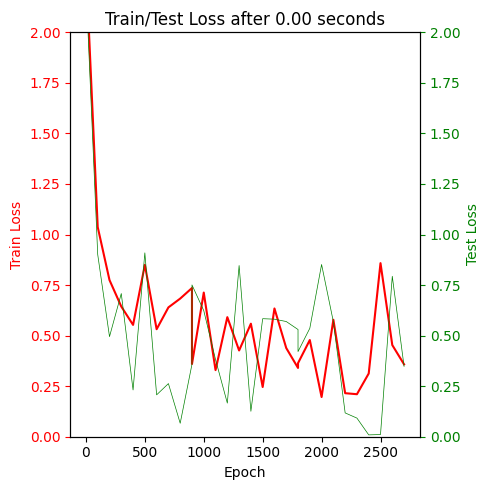

In [140]:
fig, ax1 = plt.subplots(figsize=(5, 5))
fontsize = 10
line_width = 0.5
y_axis_limit = int(max(losses['loss_train'] + losses['loss_test']) * 1.25)

ax1.plot(losses['epoch'], losses['loss_train'], color='red', label='Train Loss', linewidth=line_width + 1)
ax1.set_xlabel('Epoch', fontsize=fontsize)
ax1.set_ylabel('Train Loss', color='red', fontsize=fontsize)
ax1.tick_params('y', colors='red', labelsize=fontsize)
ax1.set_ylim(0, y_axis_limit) 

ax2 = ax1.twinx()
ax2.plot(losses['epoch'], losses['loss_test'], color='green', label='Test Loss', linewidth=line_width)
ax2.set_ylabel('Test Loss', color='green', fontsize=fontsize)
ax2.tick_params('y', colors='green', labelsize=fontsize)
ax2.set_ylim(0, y_axis_limit) 

plt.title(f'Train/Test Loss after {(losses["duration"] // 1000):.2f} seconds')
fig.tight_layout()
plt.show()

# Aftermath
## Loading and saving the model

We can utilize two functions to persist the model's result
- either putting everything to a pickel file or
- using PyTorch's state dic export feature

torch.save(obj = model.state_dict(), f = model_export)

In [ ]:
model = GPTLanguageModel()
model.load_state_dict(torch.load(model_export))
model.to(device)

In [ ]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

In [ ]:
with open('model-01.pkl', 'rb') as f:
     model = pickle.load(f)

# Use the model
Finally, apparently, we want to use the model. This simply generates new tokens for a given prompt.

In [155]:
prompt = 'Hello'
context = torch.tensor(encode(char_table, prompt), dtype=torch.long, device=device)

with torch.inference_mode():
  for iter in range(100):    
    generated_chars = decode(reverse_char_table, model.generate(context.unsqueeze(0), max_new_tokens = 10)[0].tolist())
    print(generated_chars)

Hellorld! Wo W 
Hellorld! Worlo
Hellorld! Wo Wo
Hellorllld! Wo 
Hellorlorld! Wo
Hellorlo 
Held!
Hellorlllld! Wo
Hellorld! 
Held
Hellorlor 
Hd! 
Hellorlorlld! W
Hello Wo 
Helor
Hello World! Wo
Hellorlorllld! 
Hellorlllld! 
H
Hello World! Wo
Hellorlld! 
Hel
Hellorlorld! Wo
Hellorlorlld! W
Hellorlorllld! 
Hellorlorld! Wo
Hello Wo World!
Hello Wo Worlor
Hellorlorld! or
Hello Wlld! 
He
Hellorld! Worll
Hello Wo World!
Hello Wo Wo Wor
Hellorld! Worll
Hello llllorllo
Hellorlo Worlld
Hellorlld! 
Hel
Hello Wo 
Held!
Hello World! Wo
Hellorld! Worlo
Hellorlorlo Wo 
Hello Wd! 
Helr
Hellorld! World
Hellorld! Worll
Hellorllllorlor
Hellorld! 
Held
Hellorlorllorld
Hello Worlld!rl
Hello World! Wo
Hello World! Wo
Hello d! Worlld
Hello 
Held! Wo
Hellorld! Wo Wo
Hellorlo World!
Hellorlld! 
Hel
Hello 
Hello 
H
Hellorlorllorld
Hellorld! Wo Wo
Hellorld!rlo Wo
Hellorld! Wo Wo
Hellorlorld! Wo
Hello d! Wo Wor
Hellorlorllo Wo
Hellorlorld! W

Hellorld! Worlo
Hellorlorlld! 

Hellorlld! 
Hel
Hellorld! 
Helo
Hellorld